# ALGERIAN FOREST FIRE - LOGISTIC REGRESSION



---


In [1]:
# Basic Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Model learning imports

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [3]:
DATA= "https://raw.githubusercontent.com/SAI-SRINIVASA-SUBRAMANYAM/INeuron-Classes-Assignments/main/Assignments/161022/Algerian_forest_fires_dataset_UPDATE.csv"

In [4]:
# Reading data

org_dataset = pd.read_csv(DATA,header=1)
org_dataset['Regions'] = ""

In [5]:
org_dataset.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Regions'],
      dtype='object')




---



In [6]:
indexes = org_dataset[(org_dataset['month'].isna()) | (org_dataset['month'] == 'month')].index

In [7]:
# Dropping anamolies

dataset = org_dataset.drop(indexes)

In [8]:
# renaming columns

for column in dataset.columns:
  dataset.rename(columns = { column: column.strip()}, inplace=True)

In [9]:
# Stripping exceess of space from the values

dataset['Classes'] = dataset['Classes'].str.strip()

In [10]:
# Identifying the regions

LABEL_Bejaia = 'Bejaia'
LABEL_Sidi_Bel_Abbes = 'Sidi-Bel Abbes'

dataset['Regions'].iloc[0:np.min(indexes)] = LABEL_Bejaia
dataset['Regions'].iloc[np.min(indexes):] = LABEL_Sidi_Bel_Abbes

In [11]:
# Cross validating the data

dataset[dataset['Regions'] == ""]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Regions


In [12]:
# Transforming the data

dataset['Outcome'] = dataset.apply(lambda row: 1 if row['Classes'].rstrip() == "fire" else 0, axis=1)  

# EDA

In [13]:
# Preview
dataset.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Regions,Outcome
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia,0
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,Bejaia,0
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia,0
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,Bejaia,0
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,Bejaia,0


In [14]:
# Dataset information

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 245
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          244 non-null    object
 1   month        244 non-null    object
 2   year         244 non-null    object
 3   Temperature  244 non-null    object
 4   RH           244 non-null    object
 5   Ws           244 non-null    object
 6   Rain         244 non-null    object
 7   FFMC         244 non-null    object
 8   DMC          244 non-null    object
 9   DC           244 non-null    object
 10  ISI          244 non-null    object
 11  BUI          244 non-null    object
 12  FWI          244 non-null    object
 13  Classes      244 non-null    object
 14  Regions      244 non-null    object
 15  Outcome      244 non-null    int64 
dtypes: int64(1), object(15)
memory usage: 32.4+ KB


In [15]:
# Type conversion

weather_features = {'Temperature':'int', 'RH': 'int', 'Ws': 'int','Rain': 'float'}
fwi_features = {'FFMC': 'float', 'DMC': 'float','DC': 'float','ISI': 'float','BUI': 'float','FWI': 'float'}
catg_features = ['day', 'month', 'Classes', 'Outcome', 'Regions']

dataset = dataset.astype(weather_features)
dataset = dataset.astype(fwi_features)
for catg_feature in catg_features:
  dataset[catg_feature] = dataset[catg_feature].astype('category')

In [16]:
# Validating the feature data types
dataset.dtypes

day            category
month          category
year             object
Temperature       int64
RH                int64
Ws                int64
Rain            float64
FFMC            float64
DMC             float64
DC              float64
ISI             float64
BUI             float64
FWI             float64
Classes        category
Regions        category
Outcome        category
dtype: object

In [17]:
# Describe dataset

dataset.describe()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,32.172131,61.938525,15.504098,0.760656,77.887705,14.673361,49.288115,4.759836,16.673361,7.049180
std,3.633843,14.884200,2.810178,1.999406,14.337571,12.368039,47.619662,4.154628,14.201648,7.428366
min,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,30.000000,52.000000,14.000000,0.000000,72.075000,5.800000,13.275000,1.400000,6.000000,0.700000
50%,32.000000,63.000000,15.000000,0.000000,83.500000,11.300000,33.100000,3.500000,12.450000,4.450000
75%,35.000000,73.250000,17.000000,0.500000,88.300000,20.750000,68.150000,7.300000,22.525000,11.375000
max,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000


In [18]:
# Shape of the dataset

dataset.shape

(244, 16)

In [19]:
dataset.corr()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
Temperature,1.000000,-0.654443,-0.278132,-0.326786,0.677491,0.483105,0.370498,0.605971,0.456415,0.566839
RH,-0.654443,1.000000,0.236084,0.222968,-0.645658,-0.405133,-0.220330,-0.688268,-0.349685,-0.580457
Ws,-0.278132,0.236084,1.000000,0.170169,-0.163255,-0.001246,0.076245,0.012245,0.030303,0.033957
Rain,-0.326786,0.222968,0.170169,1.000000,-0.544045,-0.288548,-0.296804,-0.347862,-0.299409,-0.324755
FFMC,0.677491,-0.645658,-0.163255,-0.544045,1.000000,0.602391,0.503910,0.740751,0.590251,0.691430
DMC,0.483105,-0.405133,-0.001246,-0.288548,0.602391,1.000000,0.875358,0.678355,0.982206,0.875191
DC,0.370498,-0.220330,0.076245,-0.296804,0.503910,0.875358,1.000000,0.503919,0.941672,0.737041
ISI,0.605971,-0.688268,0.012245,-0.347862,0.740751,0.678355,0.503919,1.000000,0.641351,0.922422
BUI,0.456415,-0.349685,0.030303,-0.299409,0.590251,0.982206,0.941672,0.641351,1.000000,0.856912
FWI,0.566839,-0.580457,0.033957,-0.324755,0.691430,0.875191,0.737041,0.922422,0.856912,1.000000


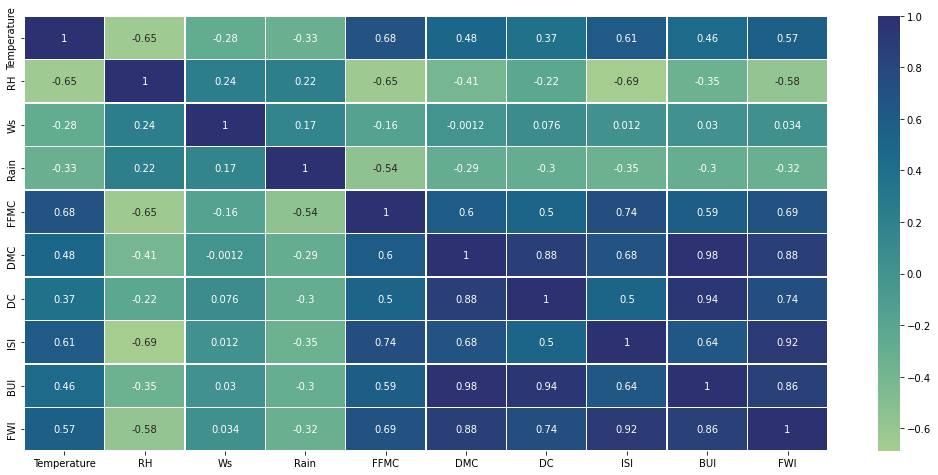

In [20]:
plt.figure(figsize=(18, 8))
sns.heatmap(dataset.corr(), annot=True, linewidth=.5, cmap="crest")

In [21]:
# Missing features

dataset.isna().sum()

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Regions        0
Outcome        0
dtype: int64

In [22]:
# Validating duplicate feature

dataset.duplicated().sum()

0

In [23]:
independent_features = []
independent_features.extend(weather_features.keys())
independent_features.extend(fwi_features.keys())

In [24]:
independent_features

['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']

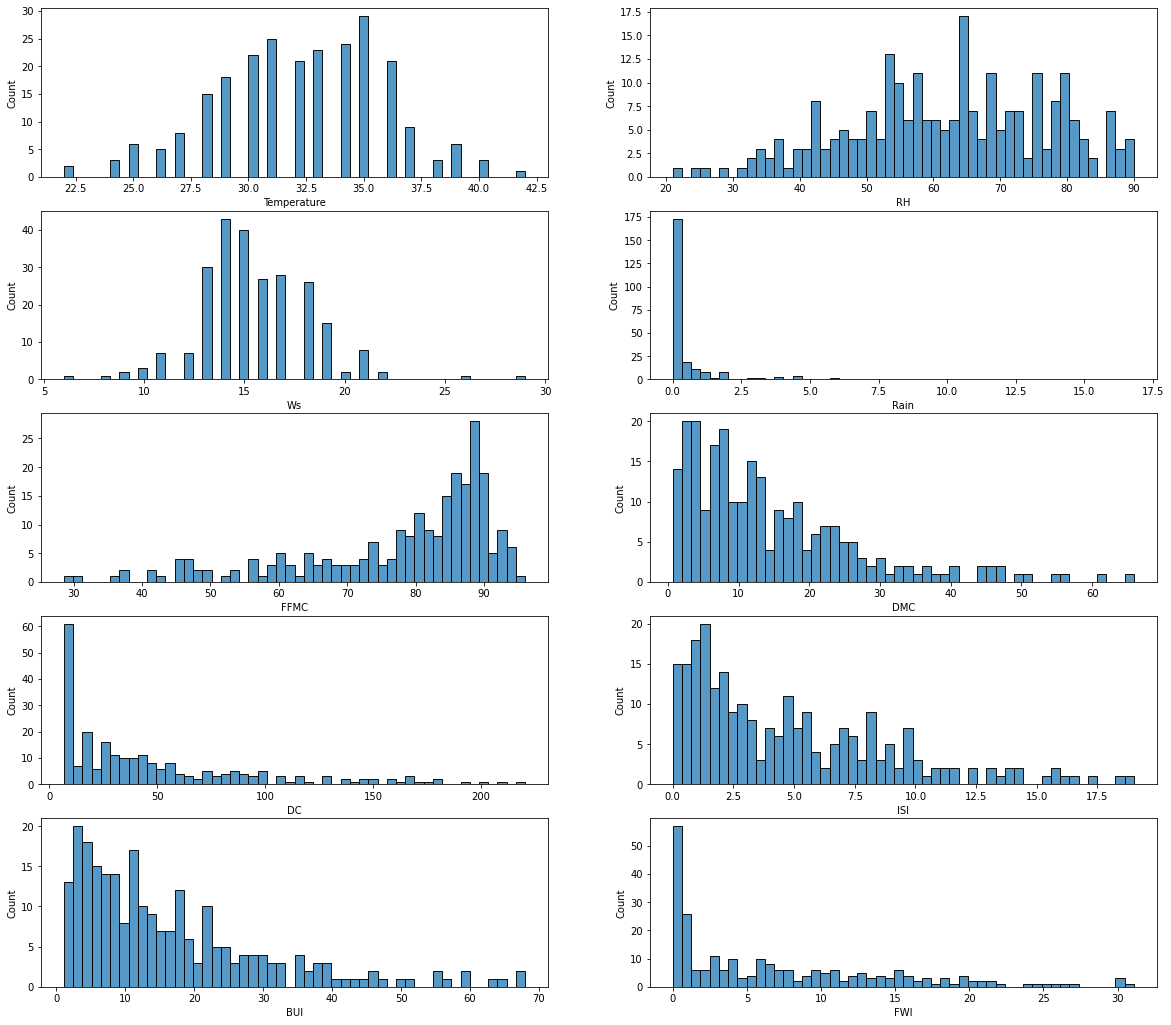

In [25]:
row, column = 0, 0
fig, axes = plt.subplots(5, 2, figsize=(20, 18))
for independent_feature in independent_features:
  sns.histplot(ax=axes[row, column],data=dataset, x=independent_feature, bins=50)
  if column == 1:
    column = 0
    row += 1
  else:
    column += 1

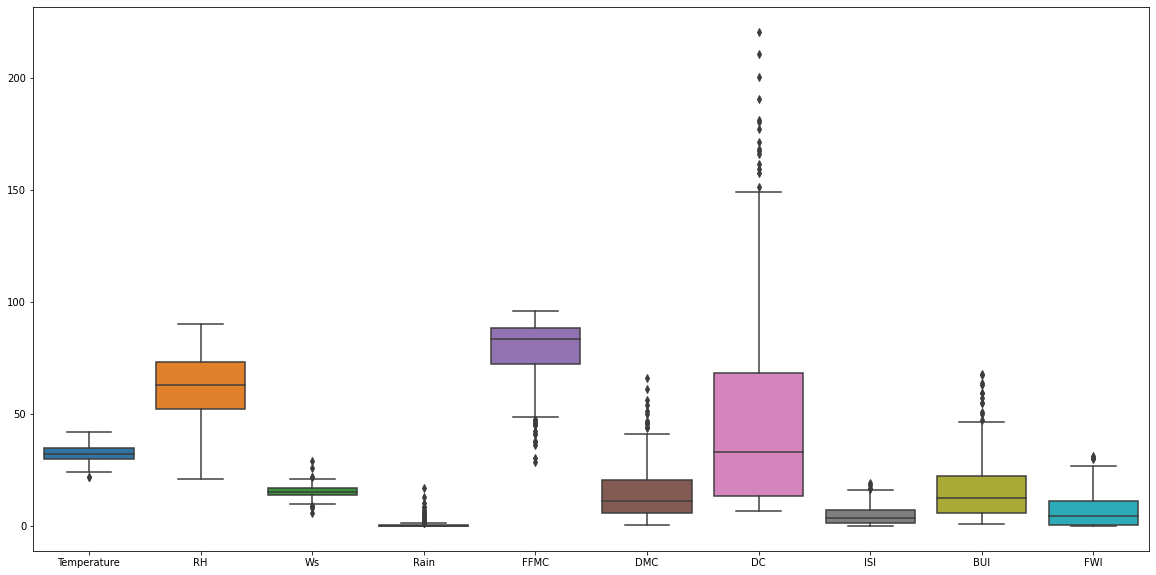

In [26]:
# Checking for outliers

plt.figure(figsize=(20, 10))
sns.boxplot(data=dataset[independent_features])

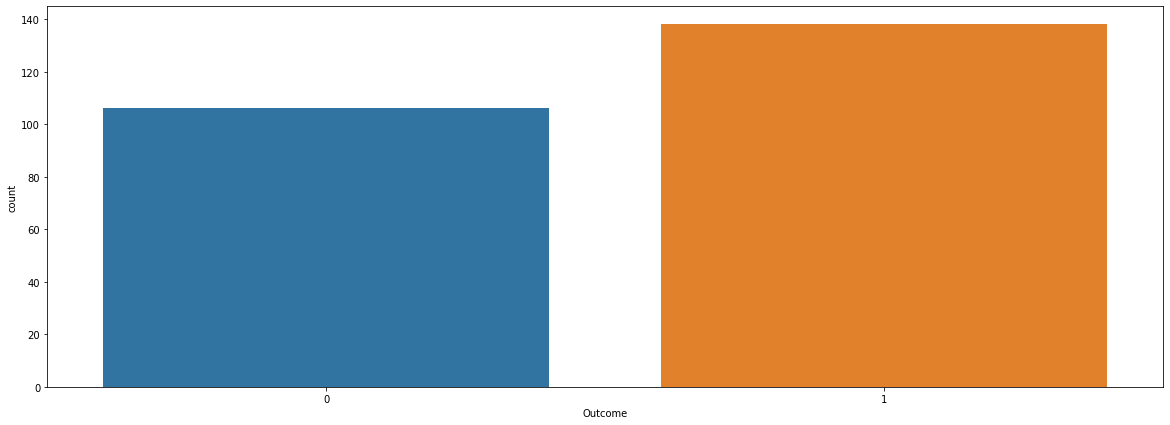

In [27]:
# Pie chart for categorical distribution

plt.figure(figsize=(20, 7))
sns.countplot(data=dataset, x='Outcome')

In [28]:
# Unique data analysis

for column in dataset.columns:
  print("-"*20)
  print("[" + column + "]")
  print(np.sort(dataset[column].unique()))
  print("-*"*10)
  print()

--------------------
[day]
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '31']
-*-*-*-*-*-*-*-*-*-*

--------------------
[month]
['06' '07' '08' '09']
-*-*-*-*-*-*-*-*-*-*

--------------------
[year]
['2012']
-*-*-*-*-*-*-*-*-*-*

--------------------
[Temperature]
[22 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42]
-*-*-*-*-*-*-*-*-*-*

--------------------
[RH]
[21 24 26 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 86 87 88 89 90]
-*-*-*-*-*-*-*-*-*-*

--------------------
[Ws]
[ 6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 26 29]
-*-*-*-*-*-*-*-*-*-*

--------------------
[Rain]
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.7  1.8  1.9  2.   2.2  2.5  2.9  3.1  3.8  4.   4.1  4.4  4.5
  4.6  4.7  5.8  6.   6.5  7.2  

In [29]:
X = dataset[independent_features]
y = dataset['Outcome']

In [30]:
X

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5
...,...,...,...,...,...,...,...,...,...,...
241,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5
242,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0
243,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2
244,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7


In [31]:
y

0      0
1      0
2      0
3      0
4      0
      ..
241    1
242    0
243    0
244    0
245    0
Name: Outcome, Length: 244, dtype: category
Categories (2, int64): [0, 1]

In [32]:
scaler = StandardScaler()

In [33]:
X_scaled = scaler.fit_transform(X)

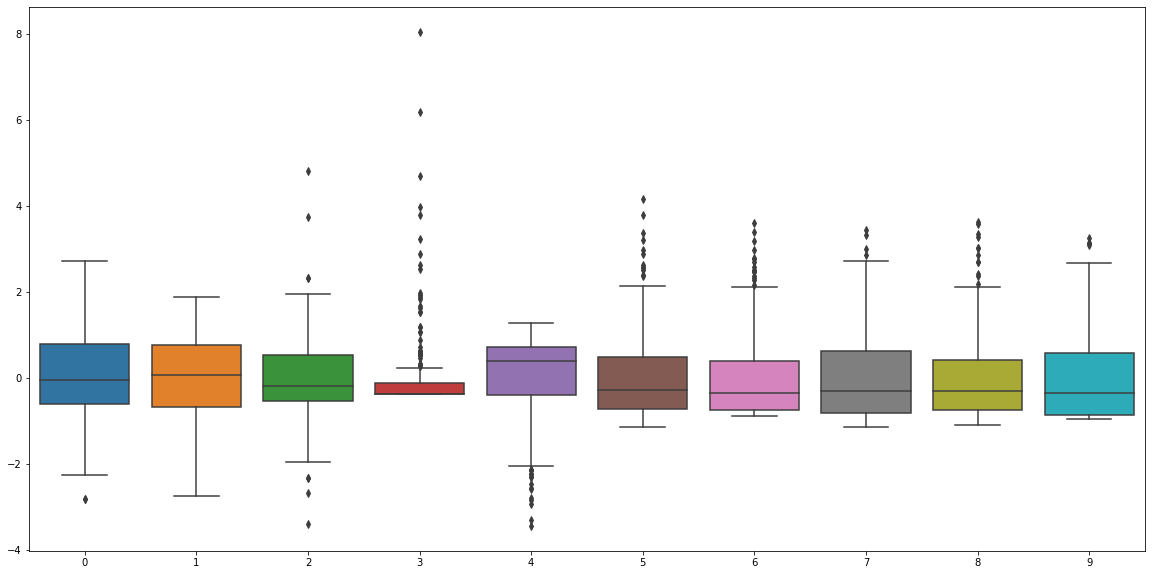

In [34]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=X_scaled)

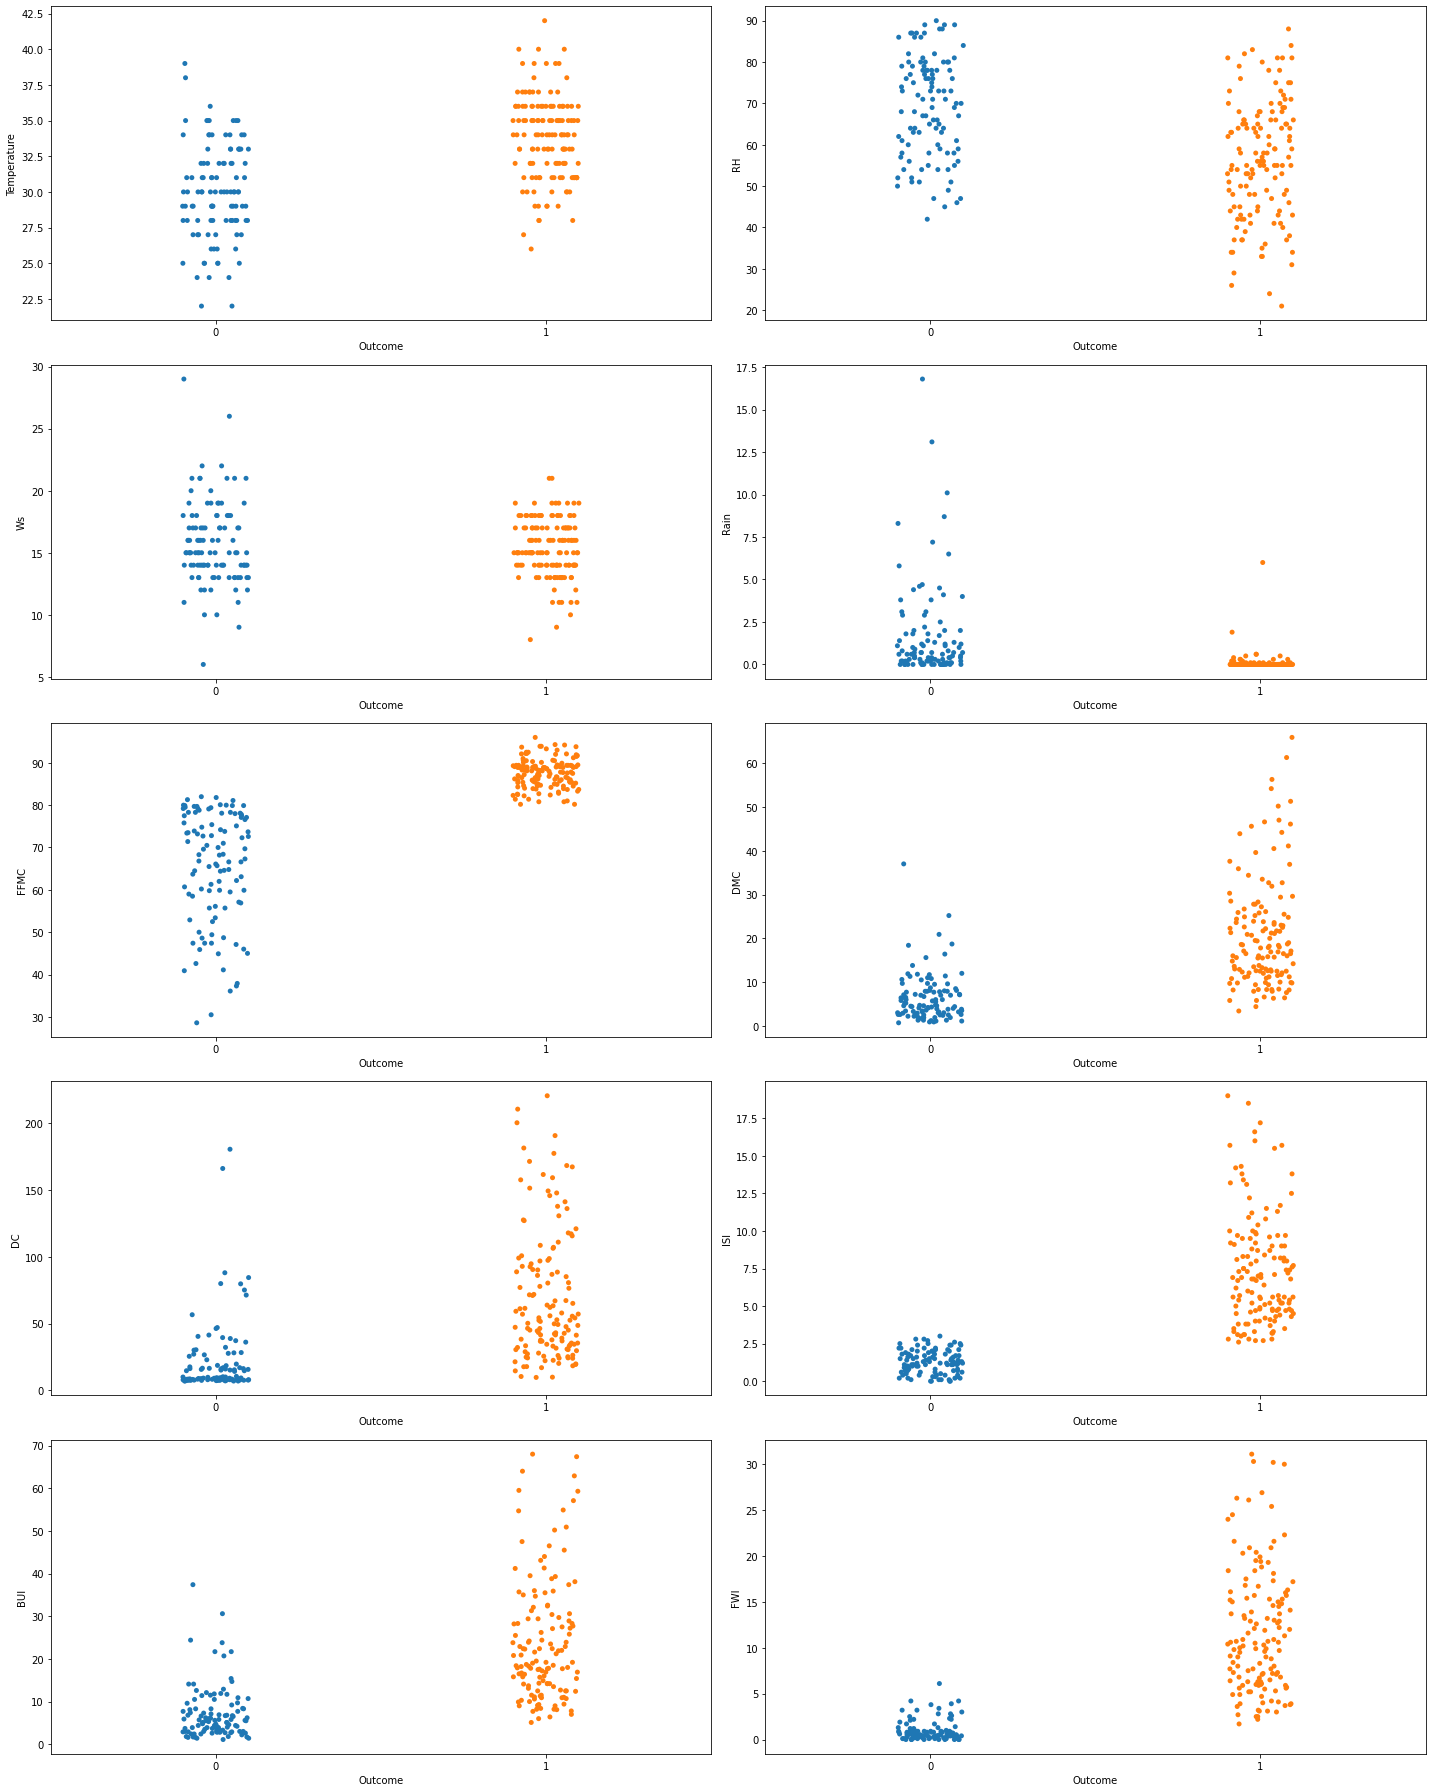

In [35]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in X:
  ax = plt.subplot(5, 2, plotnumber)
  sns.stripplot(y=X[column], x=y)
  plotnumber += 1
plt.tight_layout()

In [36]:
# Find - VIF

def VIF_Score(x):
  scaler = StandardScaler()
  arr = scaler.fit_transform(x)
  return pd.DataFrame(
      [[x.columns[i], variance_inflation_factor(arr, i)] for i in range(len(independent_features))], columns=['FEATURE', 'VIF_SCORE']
  )
  
  ### VIF FORMULA: 1/1-r**2

In [37]:
VIF_Score(X)

,FEATURE,VIF_SCORE
0,Temperature,2.319892
1,RH,2.763251
2,Ws,1.281528
3,Rain,1.539725
4,FFMC,4.109607
5,DMC,76.208113
6,DC,24.548675
7,ISI,22.931108
8,BUI,170.409228
9,FWI,40.407207


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .20, random_state = 42)

In [39]:
logr = LogisticRegression(verbose=1)

In [40]:
logr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(verbose=1)

In [41]:
# Analysis

In [42]:
y_pred = logr.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1])

In [43]:
confusion_matrix(y_test, y_pred)

array([[22,  0],
       [ 1, 26]])

In [44]:
def model_eval(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  accuracy = (tp+tn)/(tn+fp+fn+tp)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  specificity = tn/(fp+tn)
  f1_score = 2 * (recall*precision)/(recall+precision)
  return { 
      "accuracy": accuracy, 
      "precision": precision, 
      "recall": recall, 
      "specificity": specificity,
      "f1_score": f1_score
      }

In [45]:
print("Model evaluation:")
print(model_eval(y_test, y_pred))

Model evaluation:
{'accuracy': 0.9795918367346939, 'precision': 1.0, 'recall': 0.9629629629629629, 'specificity': 1.0, 'f1_score': 0.9811320754716981}


In [46]:
auc = roc_auc_score(y_test, y_pred)

print("Area under curve:", auc)

# Area of under curve should be between 0 and 1
# Between different solvers in a models higher AUC should be effective

Area under curve: 0.9814814814814814


In [47]:
fpr, tpr, thres = roc_curve(y_test, y_pred)

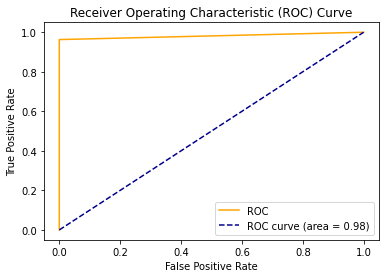

In [48]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()